In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mstats
import matplotlib.pyplot as plt
import seaborn as sns
import pystan
%matplotlib inline
plt.style.use("ggplot")

In [6]:
data = pd.read_csv('./input/data-2Dmesh.txt', header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,1.09,1.16,0.63,1.36,3.08,4.04,2.68,4.72,3.61,4.65,...,2.64,3.09,2.12,1.97,3.49,2.22,2.50,1.54,1.83,2.06
1,1.39,1.85,0.49,1.88,2.54,3.75,3.86,5.80,4.31,4.86,...,2.51,3.02,5.32,2.90,1.78,3.18,6.32,1.17,1.54,0.01
2,-0.81,2.24,0.27,2.81,4.16,3.46,6.18,8.22,5.08,4.32,...,2.75,6.12,3.49,3.15,6.03,5.03,3.64,3.91,2.48,2.86
3,2.72,1.46,1.28,4.64,4.98,5.50,6.28,6.53,5.99,7.05,...,3.45,5.19,4.53,6.14,7.07,4.30,5.19,4.94,2.30,2.30
4,0.87,-0.49,3.59,4.59,5.12,5.96,10.02,8.80,7.38,7.73,...,5.70,5.58,9.37,5.91,7.00,8.40,6.99,4.85,2.50,0.70


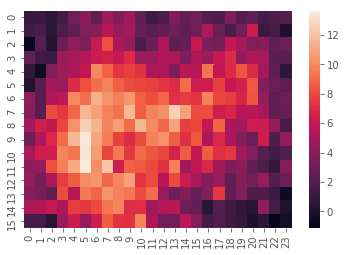

In [7]:
sns.heatmap(data)

In [9]:
data_info = pd.read_csv('./input/data-2Dmesh-design.txt', header=None)
data_info.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,88,84,60,36,63,91,45,76,73,31,...,80,55,17,10,70,9,58,53,7,92
1,81,96,35,58,53,80,18,6,55,86,...,40,88,57,7,90,8,20,35,17,26
2,51,61,51,39,79,38,70,93,33,12,...,35,41,64,67,15,6,95,5,88,56
3,15,22,1,56,29,22,34,43,30,27,...,1,55,52,27,94,47,39,87,25,71
4,18,4,76,22,18,30,69,92,9,14,...,81,7,62,17,92,66,61,21,43,77


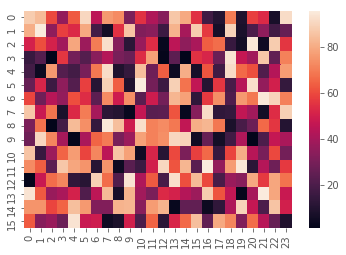

In [10]:
sns.heatmap(data_info)

In [18]:
stan_model = """

data {
  int I;
  int J;
  real Y[I, J];
  int T;
  int<lower=1, upper=T> TID[I, J];  
}

parameters {
  real r[I, J];
  real<lower=0> s_r;
  vector[T] beta;
  real<lower=0> s_beta;
  real<lower=0> s_Y;
}

model {
  for (i in 1:I){
    for (j in 3:J){
      target += normal_lpdf(r[i, j] | 2 * r[i, j-1] - r[i, j-2], s_r);
    }
  }
  for (i in 3:I){
    for (j in 1:J){
      target += normal_lpdf(r[i, j] | 2 * r[i-1, j] - r[i-2, j], s_r);
    }
  }
  
  beta ~ student_t(6, 0, s_beta);
  for (i in 1:I){
    for (j in 1:J){
      Y[i, j] ~ normal(r[i, j] + beta[TID[i, j]], s_Y);
    }
  }
}

"""

In [19]:
sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b1549962fcb024bcb829c9727554e426 NOW.


In [26]:
stan_data = {}
stan_data['I'] = data.shape[0]
stan_data['J'] = data.shape[1]
stan_data['Y'] = data
stan_data['T'] = 96
stan_data['TID'] = data_info

In [33]:
fit = sm.sampling(stan_data, seed=1)

In [34]:
fit


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_b1549962fcb024bcb829c9727554e426.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
r[1,1]    1.33    0.42   0.63   0.49   0.94   1.01   2.15   2.34      2   3.06
r[2,1]    1.53    0.45   0.66   0.68   1.07   1.36   2.32   2.61      2   4.19
r[3,1]    1.71    0.52   0.75   0.71    1.1   1.77   2.41   2.88      2    4.8
r[4,1]    1.95    0.56   0.81   0.85   1.23   2.07   2.71   3.15      2   5.25
r[5,1]     2.2    0.61   0.87   1.01    1.4   2.41   3.05   3.41      2   5.58
r[6,1]    2.48    0.64   0.91   1.22   1.61    2.7   3.38   3.68      2   5.84
r[7,1]    2.83    0.62   0.89   1.59   1.97   3.05   3.71   3.95      2   5.78
r[8,1]    3.27    0.54   0.78   2.14   2.52   3.58   4.04   4.21      2   4.97
r[9,1]    3.75    0.44   0.64   2.75   3.12    4.2   4.38   

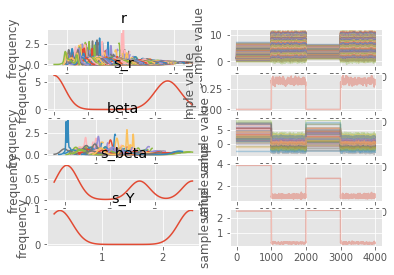

In [35]:
fig = fit.plot()

In [36]:
sample_r = fit.extract('r')['r']
sample_beta = fit.extract('beta')['beta']
sample_r.shape

(4000, 16, 24)